In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage.morphology
import skimage.measure
import skimage.segmentation
import skimage.feature
import sklearn.preprocessing
import imageio
import glob
import cv2
from scipy.spatial import distance as dist
import pyefd
import math
import sklearn.decomposition
from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import argparse
from math import atan2, cos, sin, sqrt, pi
from sklearn.svm import *
import sklearn.metrics
import scipy.io as spio

In [3]:
#------Rotation from OpenCV tutorial-----------
def getOrientation(pts, img):
    
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    
    
    cv.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    
    return angle

In [21]:
def image_preprocessing(filepath):
    img = imageio.imread(filepath)

    
    otsu_thresh = skimage.filters.threshold_otsu(img)
    img_post = np.where(img< otsu_thresh, img, 0)
    img_post = skimage.morphology.remove_small_objects(img_post, 64)
    img_post = skimage.morphology.opening(img_post, skimage.morphology.disk(15))
    img_post = skimage.morphology.closing(img_post, skimage.morphology.disk(10))
    img_mask = np.where(img_post != 0, 1, 0)
    
    #Segment the image
    img_seg = skimage.measure.label(img_mask, background = 0, connectivity=2)
    
    #Find largest segment
    max_size = 0
    layer = []
    for i in range(1, np.max(img_seg)+1):
        max_temp = np.sum(np.where(img_seg == i, 1, 0))
        if max_temp > max_size:
            max_size = max_temp
            layer.append(i)


    largest_seg = np.where(img_seg == layer[-1], True, False)
    
    #Get image orientation
    cow_mask = np.where(largest_seg == True, 255, 0).astype('uint8')
    
    
    src = cow_mask
    contours, _ = cv.findContours(src, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    for i, c in enumerate(contours):
        angle = getOrientation(c, src)
        angle = np.rad2deg(angle)-90
        if angle < -180:
            angle = angle+180


    image_center = tuple(np.array(cow_mask.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated_cow = cv2.warpAffine(cow_mask, rot_mat, cow_mask.shape[1::-1], flags=cv2.INTER_LINEAR)
    

    
    #crop the new image to be flat on top
    for i in range(np.shape(cow_mask)[0]):
        if np.sum(cow_mask[i, :]) != 0:
            len_top_row = int(np.sum(cow_mask[i, :])/255)
            break

    crop_length = abs(int(len_top_row*np.tan(abs(np.deg2rad(angle)))))
    
    
    cnt, _ = cv2.findContours(rotated_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    max_cnt = max(cnt, key=cv2.contourArea)


    reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

    max_y_crop = np.max(reshaped_contour[::, 0])
    min_y_crop = np.min(reshaped_contour[::, 0])


    max_x_crop = np.max(reshaped_contour[::, 1])
    min_x_crop = crop_length


    if min_x_crop > 10:
        cropped_cow = rotated_cow[min_x_crop-10:max_x_crop+10, min_y_crop-10:max_y_crop+10]
    if min_x_crop < 10:
        cropped_cow = rotated_cow[min_x_crop:max_x_crop+10, min_y_crop-10:max_y_crop+10]
    cnt, _ = cv2.findContours(cropped_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    max_cnt = max(cnt, key=cv2.contourArea)
    reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

    b_cow = np.where(cropped_cow>0, 1, 0)
    
    #Rotating the depth image to be the same as the mask
    #depth = imageio.imread(img_names[img_num])
    rotated_depth = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    if min_x_crop > 10:
        cropped_depth = rotated_depth[min_x_crop-10:max_x_crop+10, min_y_crop-10:max_y_crop+10]
    if min_x_crop < 10:
        cropped_depth = rotated_depth[min_x_crop:max_x_crop+10, min_y_crop-10:max_y_crop+10]
        
    masked_depth = (b_cow*cropped_depth).astype('uint16')
    
    
#     plt.figure(figsize=(10,10))
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
#     plt.title('Original Image')

#     plt.figure(figsize=(10,10))
#     plt.imshow(cow_mask, cmap='gray')
#     plt.axis('off')
#     plt.title('Largest Object')
    
#     plt.figure(figsize=(10,10))
#     plt.imshow(rotated_cow, cmap='gray')
#     plt.axis('off')
#     plt.title('Rotated Image')
    
#     plt.figure(figsize=(7,7))
#     plt.imshow(masked_depth, cmap='gray')
#     plt.axis('off')
#     plt.title('Processed Image')
    
    
    return masked_depth, b_cow

Text(0.5, 1.0, 'Mask')

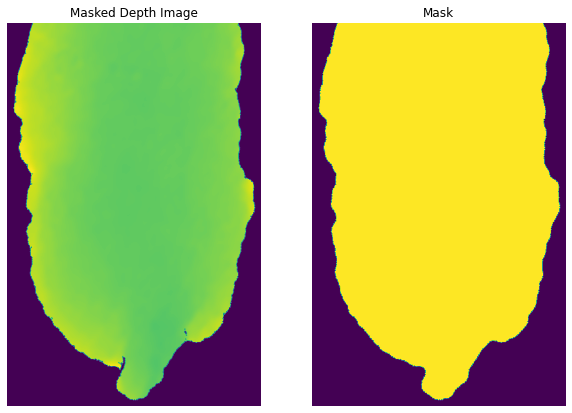

In [22]:
img_num = 4
filenames = glob.glob('Images/depth/usable/*')
img = imageio.imread(filenames[img_num])

masked_depth, mask = image_preprocessing(filenames[img_num])

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(masked_depth)
plt.axis('off')
plt.title('Masked Depth Image')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')
plt.title('Mask')

[-27750294.26928522 -26272291.21732874 -23603501.43660147
 -19252181.46620838 -13211714.72543603  -4646299.91656051
   4286257.89900889  16957431.63304829  30418896.9237767
  34306217.40136824  40615498.8327685   52448796.89329405
  40296110.65544412  26739614.85360654  14031093.95881591
   1463022.18617689  -8714650.56308429 -15338029.58958116
 -19920575.03041933 -23276430.2098609  -25544077.04438446
 -26776689.28356354 -27256206.48499403] ['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18', 'PCA_19', 'PCA_20', 'PCA_21', 'PCA_22']
(23,)


Text(0.5, 1.0, 'Kernel PCA')

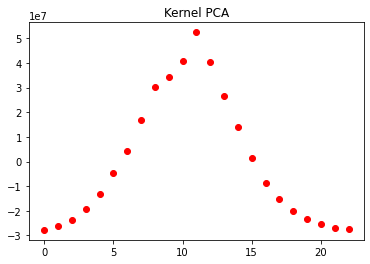

In [23]:
#----------------------Getting Kernel PCA---------------------------------
def extract_kernel_PCA(mask):
    B=skimage.measure.find_contours(mask,0.5,'high')[0]
    #print(np.shape(B))
    factor = int(np.shape(B)[0]/23)
    rem = np.shape(B)[0]%factor
    len_B = np.shape(B)[0]
    
    B_23 = np.zeros((23, 2))
    #print(B)
    #print(B_23)
    #print(np.shape(B_23))
    B_23[:, 0] = B[0:(len_B-rem):factor, 0]
    B_23[:, 1] = B[0:(len_B-rem):factor, 1]
    #print(B_23)
    kpca = sklearn.decomposition.KernelPCA(n_components = 1, kernel = 'poly')
    f = kpca.fit_transform(B_23).T[0]
    fnames = []
    for i in range(0, 23):
        fnames.append(f'PCA_{i}')

    
    return f, fnames

f, fnames = extract_kernel_PCA(mask)
print(f, fnames)
print(np.shape(f))

plt.figure()
plt.plot(f, 'ro')
plt.title('Kernel PCA')

Text(0.5, 1.0, 'Fourier Descriptors')

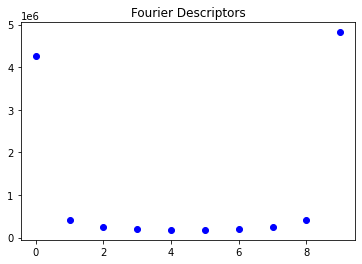

In [24]:
#------------------------Getting fourier descriptors-----------------------

def extract_boundary_features(mask):
  f = np.arange(0, 10)
  fnames = []
  fnames.append('Fourier_desc_a0')
  fnames.append('Fourier_desc_a1')
  fnames.append('Fourier_desc_a2')
  fnames.append('Fourier_desc_a3')
  fnames.append('Fourier_desc_a4')
  fnames.append('Fourier_desc_a5')
  fnames.append('Fourier_desc_a6')
  fnames.append('Fourier_desc_a7')
  fnames.append('Fourier_desc_a8')
  fnames.append('Fourier_desc_a9')

  B=skimage.measure.find_contours(mask,0.5,'high')[0]

  s = np.zeros(np.shape(B)[0], dtype=complex)
  for k in range(np.shape(B)[0]):
    s[k] = float(B[k][0]) + float(B[k][1])*1j
  
  S = scipy.fft.fft(s, n=10000)
  # print(s[1])
  # print(type(s[1]))
  for k in range(0,10):
    f[k] = np.abs(S[k*1000:(k+1)*1000].sum())
  return f, fnames


FD, fnames = extract_boundary_features(mask)

plt.figure()
plt.plot(FD, 'bo')
plt.title('Fourier Descriptors')

[1.82241515e-01 6.27560737e-03 2.16588942e-04 5.01186262e-06
 1.58965885e-10 3.83464388e-07 4.46835671e-11]


Text(0.5, 1.0, 'Hu Moments')

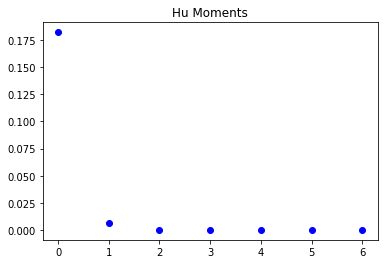

In [25]:
#----Hu Moments--------
def extract_hu_moments(mask):
    props = skimage.measure.regionprops(np.where(mask>0, 1, 0), cache=True)
    fnames = ['phi1', 'phi2', 'phi3', 'phi4', 'phi5', 'phi6', 'phi7']
    f = props[0].moments_hu
    return f, fnames


f, fnames = extract_hu_moments(mask)
print(f)

plt.figure()
plt.plot(f, 'bo')
plt.title('Hu Moments')

In [8]:
def regionprops_features(mask):
  props = skimage.measure.regionprops(mask.astype(int))
  fnames = ['area', 'convex_area', 'eccentricity','equivalent_diameter', 'euler_number', 'extent', 'filled_area','major_axis_length', 'minor_axis_length', 'perimeter', 'solidity']
  f = [props[0]['area'], props[0]['convex_area'], props[0]['eccentricity'], props[0]['equivalent_diameter'], props[0]['euler_number'], props[0]['extent'], props[0]['filled_area'],
       props[0]['major_axis_length'], props[0]['minor_axis_length'], props[0]['perimeter'], props[0]['solidity']]
  return f, fnames

f, fnames = regionprops_features(mask)
print(f, fnames)

[215576, 233121, 0.7685524319656096, 523.9082821408986, 1, 0.7457622427940831, 215576, 664.7229790887471, 425.2809928026678, 2285.5474734076133, 0.9247386550332231] ['area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity']


(array([185, 187, 195, 226, 267, 269, 278, 443, 444, 445], dtype=int64),)


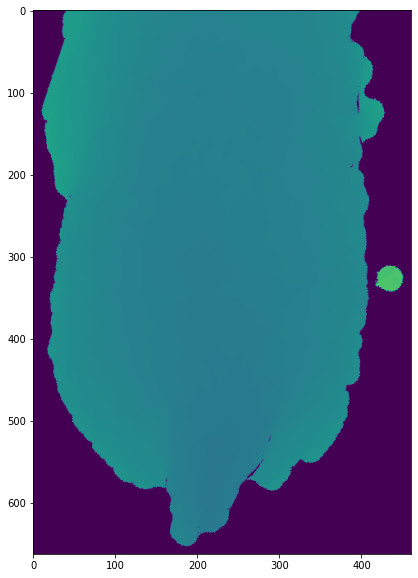

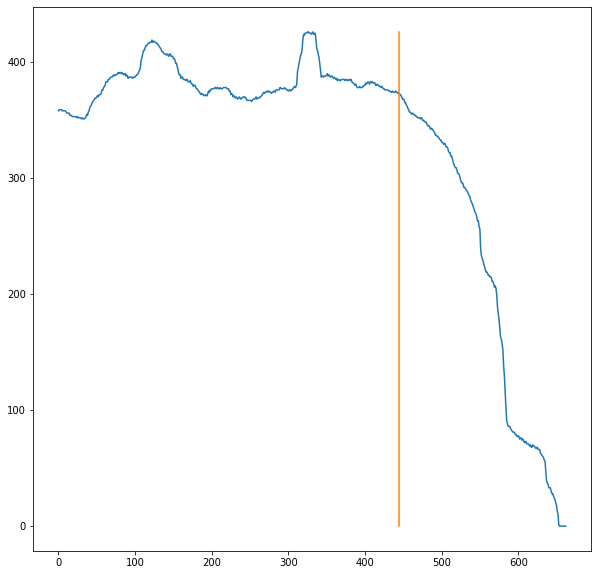

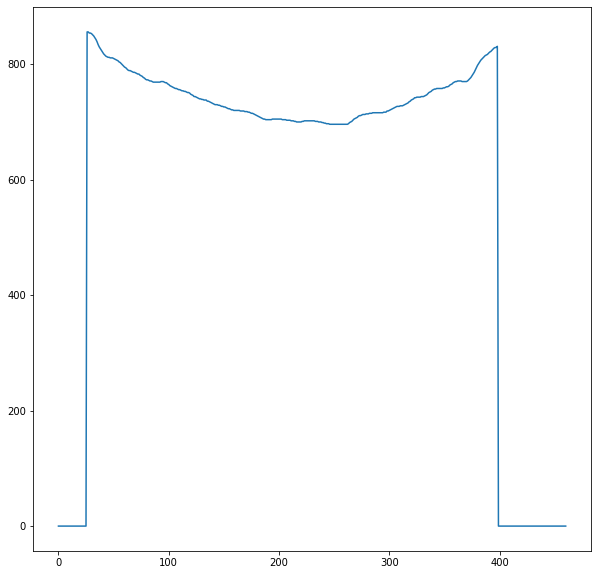

In [9]:
#Scanning the body to locate the hips

row_sums = np.sum(mask, axis=1)
if (len(row_sums)%2 == 0):
    row_sums = np.append(row_sums, 0, axis=None)
    

hip_loc = np.where(row_sums == int(np.median(row_sums)))
print((hip_loc))
if np.shape(hip_loc) != ():
    hip_loc = hip_loc[0][-1]
    

length_depth, width_depth = np.shape(masked_depth)


plt.figure(figsize=(10,10))
plt.imshow(masked_depth, cmap='gray')
masked_line = np.zeros(np.shape(mask))
masked_line[hip_loc, 0:width_depth] = np.max(mask)
plt.imshow(masked_line+masked_depth)


plt.figure(figsize=(10,10))
plt.plot(np.arange(0, len(row_sums)), row_sums)
plt.plot([hip_loc, hip_loc], [0, np.max(row_sums)])

plt.figure(figsize=(10,10))
plt.plot(masked_depth[hip_loc, 0:width_depth])


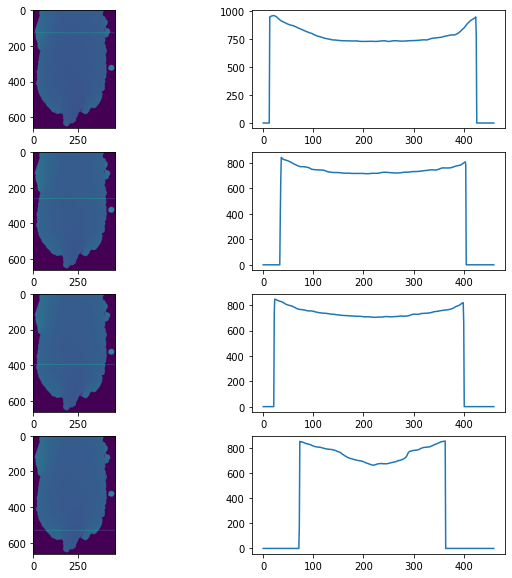

In [10]:
slice_vec = [int(length_depth/5), int(2*length_depth/5), int(3*length_depth/5), int(4*length_depth/5), length_depth]
j = 0
plt.figure(figsize=(10,10))
for i in range(1,9, 2):
    plt.subplot(4, 2, i)
    plt.imshow(masked_depth, cmap='gray')
    masked_line = np.zeros(np.shape(masked_depth))
    masked_line[slice_vec[j], 0:width_depth] = np.max(masked_depth)
    plt.imshow(masked_line+masked_depth)
    
    
    plt.subplot(4, 2, i+1)
    plt.plot(masked_depth[slice_vec[j], 0:width_depth])
    j+=1

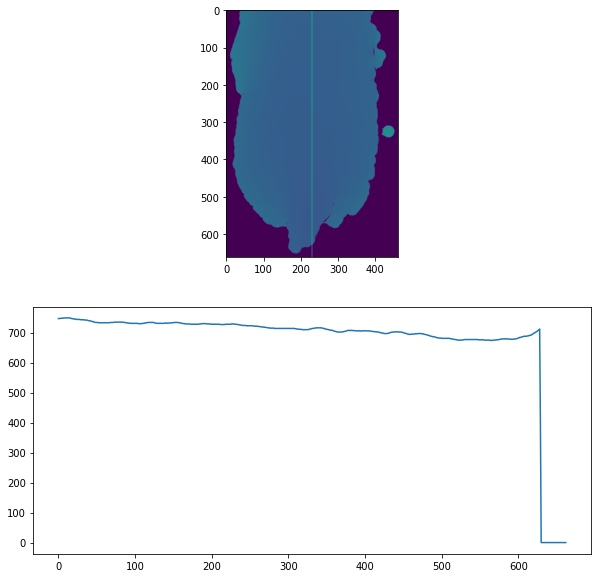

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
masked_line = np.zeros(np.shape(masked_depth))
masked_line[0:length_depth, int(width_depth/2)] = np.max(masked_depth)
plt.imshow(masked_line+masked_depth)

plt.subplot(2, 1, 2)
plt.plot(masked_depth[0:length_depth, int(width_depth/2)])

In [12]:
## Getting GLCM features
#from skimage.feature import graycomatrix, graycoprops
import skimage.feature.texture


def extract_texture_features(im, mask):
    im_1 = np.round((im/np.max(im))*31).astype(int)
    
    I_q_masked = im_1*np.where(mask >0 , 1, 0)


    G = skimage.feature.greycomatrix(I_q_masked,distances=(1,2,3,4),angles=(0,np.pi/4,np.pi/2,3*np.pi/4),levels=np.max(I_q_masked)+1,symmetric=True,normed=False)#[0:-1, 0:-1, ::, ::]
    G_temp = np.zeros(np.shape(G))
    for d in range(0,4):
        for t in range(0,4):
            G_temp[:,:,d,t]=G[:,:,d,t]/G[:,:,d,t].sum()


    contrast = skimage.feature.greycoprops(G_temp, prop='contrast')
    d0_contrast_mean = np.mean(contrast[0, ::])
    d1_contrast_mean = np.mean(contrast[1, ::])
    d2_contrast_mean = np.mean(contrast[2, ::])
    d3_contrast_mean = np.mean(contrast[3, ::])
  
    d0_contrast_std = np.std(contrast[0,::])
    d1_contrast_std = np.std(contrast[1,::])
    d2_contrast_std = np.std(contrast[2,::])
    d3_contrast_std = np.std(contrast[3,::])

    correlation = skimage.feature.greycoprops(G_temp, prop='correlation')
    d0_correlation_mean = np.mean(correlation[0, ::])
    d1_correlation_mean = np.mean(correlation[1, ::])
    d2_correlation_mean = np.mean(correlation[2, ::])
    d3_correlation_mean = np.mean(correlation[3, ::])
  
    d0_correlation_std = np.std(correlation[0,::])
    d1_correlation_std = np.std(correlation[1,::])
    d2_correlation_std = np.std(correlation[2,::])
    d3_correlation_std = np.std(correlation[3,::])

    homogeneity = skimage.feature.greycoprops(G_temp, prop='homogeneity')
    d0_homogeneity_mean = np.mean(homogeneity[0, ::])
    d1_homogeneity_mean = np.mean(homogeneity[1, ::])
    d2_homogeneity_mean = np.mean(homogeneity[2, ::])
    d3_homogeneity_mean = np.mean(homogeneity[3, ::])
  
    d0_homogeneity_std = np.std(homogeneity[0,::])
    d1_homogeneity_std = np.std(homogeneity[1,::])
    d2_homogeneity_std = np.std(homogeneity[2,::])
    d3_homogeneity_std = np.std(homogeneity[3,::])

    energy = skimage.feature.greycoprops(G_temp, prop='energy')
    d0_energy_mean = np.mean(energy[0, ::])
    d1_energy_mean = np.mean(energy[1, ::])
    d2_energy_mean = np.mean(energy[2, ::])
    d3_energy_mean = np.mean(energy[3, ::])
  
    d0_energy_std = np.std(energy[0,::])
    d1_energy_std = np.std(energy[1,::])
    d2_energy_std = np.std(energy[2,::])
    d3_energy_std = np.std(energy[3,::])


    f = [d0_contrast_mean, d1_contrast_mean, d2_contrast_mean, d3_contrast_mean, d0_contrast_std, d1_contrast_std, d2_contrast_std, d3_contrast_std,
       d0_correlation_mean, d1_correlation_mean, d2_correlation_mean, d3_correlation_mean, d0_correlation_std, d1_correlation_std, d2_correlation_std, d3_correlation_std,
       d0_homogeneity_mean, d1_homogeneity_mean, d2_homogeneity_mean, d3_homogeneity_mean, d0_homogeneity_std, d1_homogeneity_std, d2_homogeneity_std, d3_homogeneity_std,
       d0_energy_mean, d1_energy_mean, d2_energy_mean, d3_energy_mean, d0_energy_std, d1_energy_std, d2_energy_std, d3_energy_std]

    fnames = ['d0_contrast_mean', 'd1_contrast_mean', 'd2_contrast_mean', 'd3_contrast_mean', 'd0_contrast_std', 'd1_contrast_std', 'd2_contrast_std', 'd3_contrast_std',
       'd0_correlation_mean', 'd1_correlation_mean', 'd2_correlation_mean', 'd3_correlation_mean', 'd0_correlation_std', 'd1_correlation_std', 'd2_correlation_std', 'd3_correlation_std',
       'd0_homogeneity_mean', 'd1_homogeneity_mean', 'd2_homogeneity_mean', 'd3_homogeneity_mean', 'd0_homogeneity_std', 'd1_homogeneity_std', 'd2_homogeneity_std', 'd3_homogeneity_std',
       'd0_energy_mean', 'd1_energy_mean', 'd2_energy_mean', 'd3_energy_mean', 'd0_energy_std', 'd1_energy_std', 'd2_energy_std', 'd3_energy_std']
    return f, fnames


f, fnames = extract_texture_features(masked_depth, mask)
print(f, fnames)

[1.1043802295436955, 1.5643000041498216, 2.6930251042197773, 3.8365274476739204, 0.24845589738540252, 0.43631787664159355, 0.5730133350749386, 0.8056763012457385, 0.9867794398556871, 0.9812546646935143, 0.9676300685839803, 0.9537362563911167, 0.002986279827792025, 0.005254739563911082, 0.006945259057050153, 0.009826019007141041, 0.9848546153051132, 0.9804481381811547, 0.9698998654101223, 0.9593062394102492, 0.002768323643334396, 0.0045057016137448275, 0.006052345051508053, 0.008249802151067331, 0.48741631087794085, 0.48482645065327695, 0.47857248729683993, 0.47236569274083967, 0.0016031802684201412, 0.0025398663950825353, 0.0033424259023480184, 0.004582310833444493] ['d0_contrast_mean', 'd1_contrast_mean', 'd2_contrast_mean', 'd3_contrast_mean', 'd0_contrast_std', 'd1_contrast_std', 'd2_contrast_std', 'd3_contrast_std', 'd0_correlation_mean', 'd1_correlation_mean', 'd2_correlation_mean', 'd3_correlation_mean', 'd0_correlation_std', 'd1_correlation_std', 'd2_correlation_std', 'd3_correl

In [13]:
def make_X_train(category_filepath):
    category = sorted(glob.glob(category_filepath))
    image_train = category[0:int(len(category)*0.9)]
    X_train = np.zeros((int(len(image_train)), 83 ))
    y_train = []

    for images in range(int(len(image_train))):
        y_train.append(category_filepath[len('Images/depth/'):-2])
        image_path = image_train[images]
        depth_mask, mask = image_preprocessing(image_path)
        try:
            X_train[images, 0:10]= extract_boundary_features(mask)[0]
            X_train[images, 10:17]= extract_hu_moments(mask)[0]
            X_train[images, 17:28]= regionprops_features(mask)[0]
            X_train[images, 28:60]= extract_texture_features(depth_mask, mask)[0]
            X_train[images, 60:83]= extract_kernel_PCA(mask)[0]
        except IndexError: #???? I dont know why this was nessicary
            X_train[images, ::] = 0
    
    return X_train, y_train


def make_X_test(category_filepath):
    category = sorted(glob.glob(category_filepath))

    image_test = category[int(len(category)*0.9):int(len(category))]
    X_test = np.zeros(( len(image_test), 83 ))
    y_test = []

    for images in range(len(image_test)):
        y_test.append(category_filepath[len('Images/depth/'):-2])
        image_path = image_test[images]
        depth_mask, mask = image_preprocessing(image_path)
        try:
            X_test[images, 0:10]= extract_boundary_features(mask)[0]
            X_test[images, 10:17]= extract_hu_moments(mask)[0]
            X_test[images, 17:28]= regionprops_features(mask)[0]
            X_test[images, 28:60]= extract_texture_features(depth_mask, mask)[0]
            X_test[images, 60:83]= extract_kernel_PCA(mask)[0]
        except IndexError:
            X_test[images, ::] = 0

    return X_test, y_test

In [14]:
def normalize_Xtrain(X_train):
    mn = []
    mx = []
    Xn_train = np.zeros(np.shape(X_train))
    X_norm = np.zeros(np.shape(X_train))
    for i in range(len(X_train[0, ::])):
        mn.append(np.min(X_train[::, i]))
        Xn_train[::, i] = X_train[::, i] - mn[i]
    for i in range(len(X_train[0, ::])):
        mx.append(np.max(Xn_train[::, i]))
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_train[::, i]/mx[i]

    return X_norm, mx, mn

def normalize_Xtest(X_test, mx, mn):
    Xn_test = np.zeros(np.shape(X_test))
    X_norm = np.zeros(np.shape(Xn_test))
    for i in range(len(X_test[0, ::])):
        Xn_test[::, i] = X_test[::, i] - mn[i]
    for i in range(len(X_test[0, ::])):
        if mx[i] == 0:
            X_norm[::, i] = 0
        if mx[i] != 0:
            X_norm[::, i] = Xn_test[::, i]/mx[i]

    return X_norm

In [15]:
X_train1, y_train1 = make_X_train('Images/depth/usable/*')
X_test1, y_test1 = make_X_test('Images/depth/usable/*')
X_train2, y_train2 = make_X_train('Images/depth/4_test/*')
X_test2, y_test2 = make_X_test('Images/depth/4_test/*')

X_train = np.vstack((X_train1, X_train2))
y_train = y_train1+y_train2

X_test = np.vstack((X_test1, X_test2))
y_test = y_test1+y_test2

Xn_train, mx, mn= normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)

In [19]:
print(Xn_train[::, 0])
print(y_train)

[1.         0.87705882 0.85171908 0.7813557  0.         0.19023112
 1.         0.35500006 0.7813557  0.         0.06076557 0.19023112]
['usable', 'usable', 'usable', 'usable', 'usable', 'usable', '4_test', '4_test', '4_test', '4_test', '4_test', '4_test']


The accuracy is:  0.5


C:\Users\zacha\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['4_test', 'usable'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


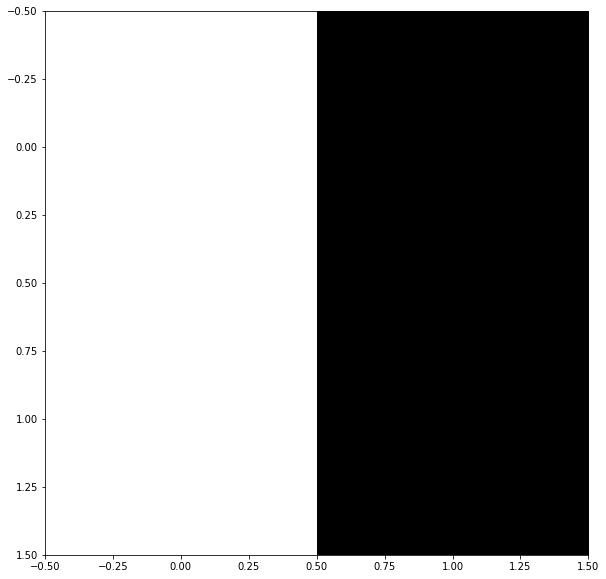

In [34]:
clf=sklearn.svm.SVC(kernel='rbf')
clf.fit(Xn_train,y_train)
y_test_hat=clf.predict(Xn_test)
C = sklearn.metrics.confusion_matrix(y_test,y_test_hat,['4_test', 'usable'])
acc=np.diag(C).sum().astype(float)/C.sum()

print('The accuracy is: ', acc)

plt.figure(figsize=(10,10))
plt.imshow(C, cmap='gray')

The SVR score is:  -0.5328005635360245


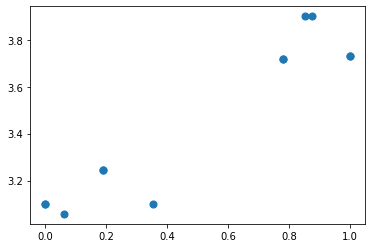

In [63]:
y_train_reg = []
for i in range(len(y_train)):
    if y_train[i] == '4_test':
        y_train_reg.append(3)
    if y_train[i] == 'usable':
        y_train_reg.append(4)

y_test_reg = []
for i in range(len(y_test)):
    if y_test[i] == '4_test':
        y_test_reg.append(3)
    if y_test[i] == 'usable':
        y_test_reg.append(4)


svr = sklearn.svm.SVR(kernel='linear')
svr.fit(Xn_train, y_train_reg)
y_test_hat=svr.predict(Xn_test)
score = svr.score(Xn_test, y_test_reg)
print('The SVR score is: ', score)

plt.figure()
plt.scatter(Xn_train[::, 0], svr.fit(Xn_train, y_train_reg).predict(Xn_train), s = 50)